In [ ]:
###########################
#Noise QFT
#search for the return probabilities, calculate stability of each case for error type
###########################

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from sympy import factorint
from fractions import Fraction
from numpy import linalg
import pandas as pd
import numpy as np
from numpy import pi
from sympy import *
import random
import math

import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import SaveDensityMatrix

from qiskit.quantum_info import Statevector

In [2]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(16, 6))

In [3]:
def qft_rotations(circuit, n, n_max,  case, position):
    tmp = n_max - case
    
    if n == 0:
        return circuit
    n -= 1    

    if n  == tmp:
        errori(circuit, position, n)  
        
    circuit.h(n)   
    
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    qft_rotations(circuit, n, n_max, case, position)

In [4]:
def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

In [5]:
def errori(circuit, position, n):
    epsilon = 1                          
    extracted = random.uniform(0, 1)
    
    if (extracted < epsilon):    
        circuit.x(position)          #--------------------error type choice
    circuit.barrier(range(n))
    return circuit

In [6]:
def qft(circuit, n, n_max, case, position):
    if case == 1:
        errori(circuit, position, n) 

    qft_rotations(circuit, n, n_max, case, position)

    if case == n + 1:
        errori(circuit, position, n)
    #circuit.barrier(range(n))
    swap_registers(circuit, n)    

    if case == n + 2:
        errori(circuit, position , n)
        
    if case == 0:
        print(' ')
        
    if case > n + 2:
        print('Error: case value incorrect')
    return circuit

In [7]:
def split_circuit_by_barrier(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('barrier'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))

In [8]:
def split_circuit_by_error(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('x'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))
        

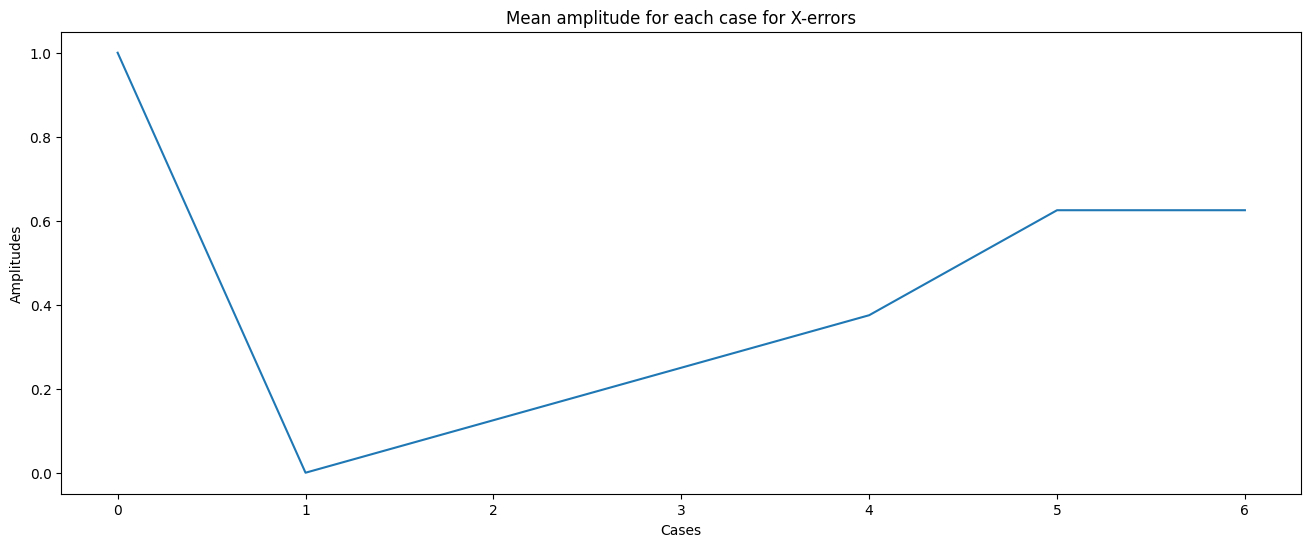

In [9]:
n = 4

#Each line contains the results of the aplitude for each state of the complete basis
amplitudes = np.empty((n + 3, n))
x = []

#change case (0, n + 2) and position (0,n - 1), case = 0 means no errors
for case in range(0, n + 3):
    for position in range(n):
        
        control = QuantumRegister(n, 'r1')
        circuit = QuantumCircuit(control)
        #print(case, position)

        qft(circuit, n, n, case, position) 
        circuit.draw(fold = -1, scale = 0.5) 

        for subcircuit in (split_circuit_by_barrier(circuit)):
            circuit_right = subcircuit
            
        for subcircuit in (split_circuit_by_error(circuit)):
            circuit_left = subcircuit

        circuit_right = circuit_right.inverse()

        merge = circuit_left.compose(circuit_right)
        merge.draw(fold = -1, scale = 0.5)

        backend = Aer.get_backend('unitary_simulator')
        job = execute(merge, backend, shots = 8192)
        result = job.result()
        UeU = result.get_unitary(merge,3)
        #print(UeU)
        
        #Ciclo sugli stati iniziali
        summa_states = 0
        for iii in range(2**n):   

            label = bin(iii).lstrip('-0b').zfill(n)
            #print(label)
            #create list of label for plot
            if case == 0:
                x.append(label)
                
            state = Statevector.from_label(label)
            summa_states = summa_states + (state.evolve(UeU)[label]**2).real
            iii += 1
            state = 0
            amplitudes[case][position] = summa_states
        merge = 0
        result = 0
        circuit = 0
        UeU = 0

#print(amplitudes.sum(axis = 1)/(n*(2**n)))
plt.xlabel('Cases')
plt.ylabel('Amplitudes')
plt.title('Mean amplitude for each case for X-errors')
plt.plot(amplitudes.sum(axis = 1)/(n*(2**n)))
#plt.savefig('caseX.pdf', format = 'pdf') 
#plt.savefig('caseZ.pdf', format = 'pdf') 